### Finite Mixture Models - Description and Coded Example
##### Sam Leonard

Here's a quick description and coded example of a finite mixture model.  

According to Wikipedia, the average American male is $5$ feet $9.5$ inches tall, and the average American female is $5'4''$.  Let's assume that heights for both men and women are normally distributed around their respective means, with a standard deviation of $1$.  Let's also assume the American population is is $50\%$ female and $50\%$ male.

Under these assumptions, the probability density function of the height of a randomly selected American is:

$$p(y| \theta_{1} = 69.5, \theta_{2} = 64, \sigma^{2} = 1) = (\frac{1}{2})*N(69.5, 1) + (\frac{1}{2})*N(64, 1)$$

In other words, the height probability is expressed as a mixture of two distinct distributions.  This is a finite mixture model.  

In general, these models take the form:

$$p(y| \theta_{1}, ..., \theta_{K}, \lambda_{1}, ..., \lambda_{k}) = \sum_{i = 1}^{K}\lambda_{i}p(y|\theta_{i})$$

Here the $\theta_{i}$ represent parameters for a probability distribution, and the $\lambda_{i}$ represent the probability $y$ is drawn from distribution $i$ so that $\sum \lambda_{i}= 1$.

Finite mixture models are useful for describing data that you assume to be drawn from two or more distinct distributions, but you're not sure which data points correspond to which distributions.    

In the height example, we knew $\lambda$, $\theta_{1}$, and $\theta_{2}$.  In general this probably won't be the case.  However, given some data, we can use Bayesian statistics to generate reasonable estimates for these parameters.  

Below is Python code that performs this estimation and creates a graph to help visualize the results.



In [26]:
%matplotlib inline
import matplotlib
import numpy as np
from scipy.stats import norm, dirichlet

sigma = 1
data1 = norm.rvs(69.5, sigma, 50)
data2 = norm.rvs(64, sigma, 50)
data = np.append(data1, data2)

Here's a dataset consisting of $50$ random draws each from two distinct normal distributions.  The first with a mean of $69.5$, the mean height in inches of American males, and the second with mean $64$, the mean height of American females.  

In [27]:
K = 30
alpha = 1
n = len(data)
tau = 10
mu0 = 66.75
theta_vector = norm.rvs(mu0, tau, K)
p = np.repeat(1/K, K)
c = np.random.choice(range(0, K), n, replace = True)

Here are our prior parameters and starting values for the MCMC.  

In [28]:
niter = 100
thetaSam = np.zeros( (niter, K) )
cSam = np.zeros( (niter, n) )
pSam = np.zeros( (niter, K) )

Arrays to store the results of our estimation.

In [29]:
for u in range(niter):
    unique_c = list(set(c))
    for j in unique_c:
        indices = [i for i, x in enumerate(c) if x == j]
        sum_yi = sum(data[i] for i in indices)
        nj = len(indices)
        post_var = 1/(nj/sigma**2+1/tau**2)
        post_mean = (sum_yi/sigma**2)*post_var
        theta_vector[j] = float(norm.rvs(post_mean, post_var**.5, 1))
    
    for j in range(0, n):    
        dist = norm.pdf(data[j], theta_vector, sigma)
        probs = list(i * j for i, j in zip(p, dist))
        probs_normalized = list(i/sum(probs) for i in probs)
        c[j] = int(np.random.choice(range(0, K), 1, p=probs_normalized))
    
    c_extended = np.append(c, np.arange(30))
    counts = np.unique(c_extended, return_counts = True)[1] - 1
    alpha_updated = list(i + alpha/K for i in counts)
    p = dirichlet.rvs(alpha_updated, 1)
    p = p[0].tolist()

    thetaSam[u] = theta_vector
    cSam[u] = c
    pSam[u] = p
    


This is the MCMC, the Bayesian algorithm we are using to estimate the parameters of our finite mixture model.

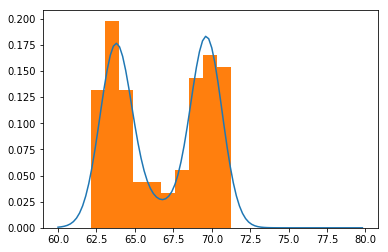

In [30]:
grid = np.arange(60, 80, .2)
fsam = np.zeros( (niter, len(grid)) ) 

for i in range(0, niter):
    fsam[i, ] = [sum(pSam[i, ]*norm.pdf(x, thetaSam[i, ], sigma)) for x in grid]

fy = [np.mean(fsam[:, x]) for x in range(0, len(grid))] 


l = matplotlib.pyplot.plot(grid, fy)
h = matplotlib.pyplot.hist(data, 10, density = True)
matplotlib.pyplot.show()

And here we have a plot of our results.  The orange bars are a normalized histogram of the dataset.  The blue curve is the probability density function estimated from the MCMC.  Looks good!

In the above example, the data was drawn equally from $N(69.5, 1)$ and $N(64, 1)$.  This of course may not always be the case.  Our height data may be drawn from a population that is $75\%$ women and $25\%$ men, for example.

Here's what the MCMC looks like in this case.

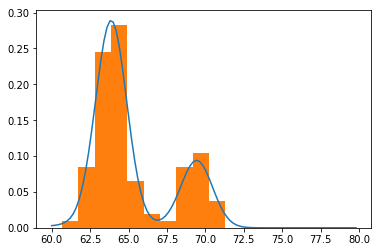

In [31]:
data1 = norm.rvs(69.5, sigma, 25)
data2 = norm.rvs(64, sigma, 75)
data = np.append(data1, data2)
thetaSam = np.zeros( (niter, K) )
cSam = np.zeros( (niter, n) )
pSam = np.zeros( (niter, K) )

for u in range(niter):
    unique_c = list(set(c))
    for j in unique_c:
        indices = [i for i, x in enumerate(c) if x == j]
        sum_yi = sum(data[i] for i in indices)
        nj = len(indices)
        post_var = 1/(nj/sigma**2+1/tau**2)
        post_mean = (sum_yi/sigma**2)*post_var
        theta_vector[j] = float(norm.rvs(post_mean, post_var**.5, 1))
    
    for j in range(0, n):    
        dist = norm.pdf(data[j], theta_vector, sigma)
        probs = list(i * j for i, j in zip(p, dist))
        probs_normalized = list(i/sum(probs) for i in probs)
        c[j] = int(np.random.choice(range(0, K), 1, p=probs_normalized))
    
    c_extended = np.append(c, np.arange(30))
    counts = np.unique(c_extended, return_counts = True)[1] - 1
    alpha_updated = list(i + alpha/K for i in counts)
    p = dirichlet.rvs(alpha_updated, 1)
    p = p[0].tolist()

    thetaSam[u] = theta_vector
    cSam[u] = c
    pSam[u] = p
    
grid = np.arange(60, 80, .2)
fsam = np.zeros( (niter, len(grid)) ) 

for i in range(0, niter):
    fsam[i, ] = [sum(pSam[i, ]*norm.pdf(x, thetaSam[i, ], sigma)) for x in grid]

fy = [np.mean(fsam[:, x]) for x in range(0, len(grid))] 


l = matplotlib.pyplot.plot(grid, fy)
h = matplotlib.pyplot.hist(data, 10, density = True)
matplotlib.pyplot.show()

Looks good again!  

This is, of course, a very simple example of a finite mixture model.  These models can be used to estimate densities for populations with more than two components, for example.  

I will continue to add to this write-up as time permits.  In the meantime feel free to e-mail me with any feedback: SamuelJLeonard@gmail.com

Thanks for reading!